In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
import numpy as np
import scipy.io as sio
import scipy.misc
import math
import pickle
from random import randint
import os
import os.path
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
def GCN(data_dir, ratio):
    train_data = sio.loadmat(data_dir)
    x_train = train_data['X']
    y_train = train_data['y']
    y_train[y_train == 10] = 0
    x_train = x_train.transpose((3,0,1,2))
    x_train.astype(float)
    x_gray = np.dot(x_train, [[0.2989],[0.5870],[0.1140]])

    imsize = x_gray.shape[0]
    mean = np.mean(x_gray, axis=(1,2), dtype=float)
    std = np.std(x_gray, axis=(1,2), dtype=float, ddof=1)
    std[std < 1e-4] = 1
    x_GCN = np.zeros(x_gray.shape, dtype=float)
    for i in np.arange(imsize):
        x_GCN[i,:,:] = (x_gray[i,:,:] - mean[i]) / std[i]
    nums = x_GCN.shape[0]
    x_GCN = x_GCN.reshape((nums,-1))
    data = np.hstack((y_train,x_GCN))
    np.random.shuffle(data)
    cut=math.floor(nums*ratio)
    train,val = data[:cut,:], data[cut:,:]

    print("\n------- GCN done -------")
    return train, val

In [3]:
def read_SVHN(data_dir, ratio, batch_size):

    train,val = GCN(data_dir, ratio)
    img_width = 32
    img_height = 32
    img_depth = 1
    label_bytes = 1
    image_bytes = 1024
    record_bytes = 1025

    with tf.name_scope('input'):
        images_list = []
        label_batch_list = []
        for train_val in [train, val]:
            q = tf.train.input_producer(train_val)
            input_data = q.dequeue()

            label = tf.slice(input_data , [0], [1])
            label = tf.cast(label, tf.int32)

            image_raw = tf.slice(input_data , [1], [1024])
            image_raw = tf.reshape(image_raw, [1, 32, 32])
            image = tf.transpose(image_raw, (1,2,0))
            image = tf.cast(image, tf.float32)
            images, label_batch = tf.train.batch([image, label],
                                                batch_size = batch_size,
                                                num_threads = 16,
                                                capacity= 2000)

            n_classes = 10
            label_batch = tf.one_hot(label_batch, depth = n_classes)

            label_batch_list.append(tf.reshape(label_batch, [batch_size, n_classes]))
            images_list.append(images)


        return images_list, label_batch_list

In [4]:
def conv(layer_name, x, out_channels, kernel_size=[5,5], stride=[1,1,1,1]):
    '''Convolution op wrapper, use RELU activation after convolution
    Args:
        layer_name: e.g. conv1, pool1...
        x: input tensor, [batch_size, height, width, channels]
        out_channels: number of output channels (or comvolutional kernels)
        kernel_size: the size of convolutional kernel, VGG paper used: [3,3]
        stride: A list of ints. 1-D of length 4. VGG paper used: [1, 1, 1, 1]
        is_pretrain: if load pretrained parameters, freeze all conv layers.
        Depending on different situations, you can just set part of conv layers to be freezed.
        the parameters of freezed layers will not change when training.
    Returns:
        4D tensor
    '''

    in_channels = x.get_shape()[-1]
    with tf.variable_scope(layer_name):
        w = tf.get_variable(name='weights',
                            shape=[kernel_size[0], kernel_size[1], in_channels, out_channels],
                            initializer=tf.contrib.layers.xavier_initializer()) # default is uniform distribution initialization
        b = tf.get_variable(name='biases',
                            shape=[out_channels],
                            initializer=tf.constant_initializer(0.0))
        x = tf.nn.conv2d(x, w, stride, padding='SAME', name='conv')
        x = tf.nn.bias_add(x, b, name='bias_add')
        x = tf.nn.relu(x, name='relu')
        return x

In [5]:
def pool(layer_name, x, kernel=[1,2,2,1], stride=[1,2,2,1]):
    '''Pooling op
    Args:
        x: input tensor
        kernel: pooling kernel, VGG paper used [1,2,2,1], the size of kernel is 2X2
        stride: stride size, VGG paper used [1,2,2,1]
        padding:'SAME'
    '''
    
    x = tf.nn.max_pool(x, kernel, strides=stride, padding='SAME', name=layer_name)
    return x

In [6]:
def FC_layer(layer_name, x, out_nodes):
    '''Wrapper for fully connected layers with RELU activation as default
    Args:
        layer_name: e.g. 'FC1', 'FC2'
        x: input feature map
        out_nodes: number of neurons for current FC layer
    '''
    shape = x.get_shape()
    size = shape[1].value * shape[2].value * shape[3].value

    with tf.variable_scope(layer_name):
        w = tf.get_variable('weights',
                            shape=[size, out_nodes],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('biases',
                            shape=[out_nodes],
                            initializer=tf.constant_initializer(0.0))
        flat_x = tf.reshape(x, [-1, size]) # flatten into 1D

        x = tf.nn.bias_add(tf.matmul(flat_x, w), b)
        x = tf.nn.relu(x)
        return x

In [7]:
def final_layer(layer_name, x, out_nodes):
    shape = x.get_shape()
    size = shape[-1].value
    with tf.variable_scope(layer_name):
        w = tf.get_variable('weights',
                            shape=[size, out_nodes],
                            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable('biases',
                            shape=[out_nodes],
                            initializer=tf.constant_initializer(0.0))
        flat_x = tf.reshape(x, [-1, size]) # flatten into 1D
        x = tf.nn.bias_add(tf.matmul(flat_x, w), b)
        return x

In [8]:
def drop_out(layer_name, x, keep_prob = 0.5):
    with tf.variable_scope(layer_name):
        x = tf.nn.dropout(x, keep_prob)
        return x

In [9]:
def lossFn(logits, labels):
    with tf.variable_scope('loss') as scope:
        labels = tf.cast(labels, tf.int64)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits\
                        (logits=logits, labels=labels, name='loss')
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name+'/loss', loss)
    return loss

In [10]:
def accuracyFn(logits, labels):
  """Evaluate the quality of the logits at predicting the label.
  Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor,
  """
  with tf.name_scope('accuracy') as scope:
      correct = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
      correct = tf.cast(correct, tf.float32)
      accuracy = tf.reduce_mean(correct)*100.0
      tf.summary.scalar(scope+'/accuracy', accuracy)
  return accuracy

In [11]:
def optimize(loss, learning_rate, global_step):
    '''optimization, use Gradient Descent as default
    '''
    with tf.name_scope('optimizer'):
        # optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss, global_step=global_step)
        return train_op

In [12]:
N_CLASSES = 10
IMG_W =  32 # resize the image, if the input image is too large, training will be very slow.
IMG_H = 32
RATIO = 0.2 # take 20% of dataset as validation data
BATCH_SIZE = 64
TEST_BATCH_SIZE = 20
CAPACITY = 20
MAX_STEP = 10 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001

data_dir = './data/SVHN/train_32x32.mat'
bin_dir = './data/SVHN/'
train_log_dir = './logs/train/'
val_log_dir = './logs/val/'

In [13]:
with tf.name_scope('input'):

    image_batch, label_batch  = read_SVHN(data_dir = data_dir,
                                                        ratio = 0.1,
                                                        batch_size = 64)
    tra_image_batch = image_batch[0]
    tra_label_batch = label_batch[0]

    val_image_batch = image_batch[1]
    val_label_batch = label_batch[1]




x = tf.placeholder(tf.float32, shape=[BATCH_SIZE, IMG_W, IMG_H, 1])
y_ = tf.placeholder(tf.int16, shape=[BATCH_SIZE,N_CLASSES])


c1 = conv('conv1', x, 16)
p1 = pool('pool1', c1)

c2 = conv('conv2', p1, 64)
p2 = pool('pool2', c2)

c3 = conv('conv3', p2, 128)
p3 = pool('pool3', c3)

fc = FC_layer('fc4', p3, out_nodes = 64)
do = drop_out('drop_out', fc, keep_prob = 0.5)
logits = final_layer('softmax', do, out_nodes=N_CLASSES)

loss = lossFn(logits, y_)
accuracy = accuracyFn(logits, y_)

my_global_step = tf.Variable(0, name='global_step', trainable=False)
train_op = optimize(loss, learning_rate, my_global_step)


summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    tra_summary_writer = tf.summary.FileWriter(train_log_dir, sess.graph)
    val_summary_writer = tf.summary.FileWriter(val_log_dir, sess.graph)


    try:
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                break
            tra_images,tra_labels = sess.run([tra_image_batch, tra_label_batch])
            _, tra_loss, tra_acc = sess.run([train_op, loss, accuracy], feed_dict={x:tra_images, y_:tra_labels})
            
            if step % 5 == 0 or (step + 1) == MAX_STEP:

                print ('Step: %d, loss: %.4f, accuracy: %.4f%%' % (step, tra_loss, tra_acc))
                _, summary_str = sess.run([train_op, summary_op], feed_dict={x: tra_images, y_: tra_labels})
                tra_summary_writer.add_summary(summary_str, step)

            if step % 5 == 0 or (step + 1) == MAX_STEP:
                val_images, val_labels = sess.run([val_image_batch, val_label_batch])
                val_loss, val_acc = sess.run([loss, accuracy], feed_dict={x:val_images,y_:val_labels})

                print('**  Step %d, val loss = %.2f, val accuracy = %.2f%%  **' %(step, val_loss, val_acc))
                _, summary_str = sess.run([train_op, summary_op], feed_dict={x: val_images, y_: val_labels})
                val_summary_writer.add_summary(summary_str, step)
                
            if step == (MAX_STEP - 1):
                c1_v = sess.run(c1, feed_dict={x:tra_images})
                p1_v = sess.run(p1, feed_dict={c1:c1_v})
                c2_v = sess.run(c2, feed_dict={p1:p1_v})
                p2_v = sess.run(p2, feed_dict={c2:c2_v})
                c3_v = sess.run(c3, feed_dict={p2:p2_v})
                p3_v = sess.run(p3, feed_dict={c3:c3_v})

    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')

    finally:
        coord.request_stop()
    coord.join(threads)


------- GCN done -------
Step: 0, loss: 2.3196, accuracy: 3.1250%
**  Step 0, val loss = 2.28, val accuracy = 14.06%  **
Step: 5, loss: 2.2948, accuracy: 12.5000%
**  Step 5, val loss = 2.25, val accuracy = 20.31%  **
Step: 9, loss: 2.2297, accuracy: 18.7500%
**  Step 9, val loss = 2.36, val accuracy = 10.94%  **


In [14]:
def unpool(value, name='unpool'):
    """N-dimensional version of the unpooling operation from
    https://www.robots.ox.ac.uk/~vgg/rg/papers/Dosovitskiy_Learning_to_Generate_2015_CVPR_paper.pdf
    :param value: A Tensor of shape [b, d0, d1, ..., dn, ch]
    :return: A Tensor of shape [b, 2*d0, 2*d1, ..., 2*dn, ch]
    """
    with tf.name_scope(name) as scope:
        sh = value.get_shape().as_list()
        dim = len(sh[1:-1])
        out = (tf.reshape(value, [-1] + sh[-dim:]))
        for i in range(dim, 0, -1):
            out = tf.concat([out, out],i)
        out_size = [-1] + [s * 2 for s in sh[1:-1]] + [sh[-1]]
        out = tf.reshape(out, out_size, name=scope)
    return out

In [15]:
w1 = [v for v in tf.trainable_variables() if v.name == "conv1/weights:0"][0]

#Reconstruction from the layer CNV-1
featuresReLu_1 = tf.placeholder(tf.float32,[None, 16, 16, 16])
unPool_1 = unpool(featuresReLu_1)
unReLu_1 = tf.nn.relu(unPool_1)
unBias_1 = unReLu_1
#unConv = tf.nn.conv2d_transpose(unBias, W_conv1, output_shape=[1,28,28,1] , strides=[1,1,1,1], padding="SAME")
unConv_1 = tf.nn.conv2d_transpose(unBias_1, w1, output_shape=[64,32,32,1] , strides=[1,1,1,1], padding="SAME")

In [16]:
activations1 = p1_v
activations2 = p2_v
activations3 = p3_v

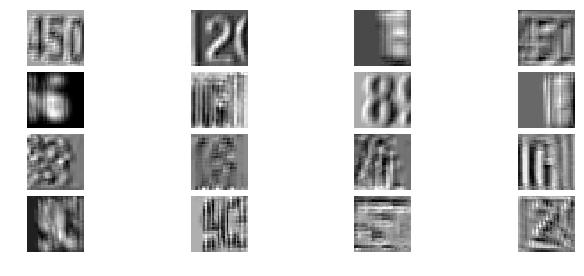

In [17]:
plt.figure(num='CNV1',figsize=(10,8))
for i in range(16):
    isolated = activations1.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0#These two lines set all other features other than feature i to 0
    #print (isolated.shape)
    totals = np.sum(isolated,axis=(1,2,3))
    best = np.argmax(totals,axis=0)
    #These two lines are particular for batch of images.
    #That means choose one image from this batch of images which feacture i can judge best.
    #print (totals)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        pixelactive = sess.run(unConv_1, feed_dict={featuresReLu_1: isolated})
    #print(pixelactive.shape) 
    plt.subplot(4,4,i+1)    
    plt.imshow(pixelactive[best,:,:,0],cmap="gray")
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)
plt.show()

In [18]:
w2 = [v for v in tf.trainable_variables() if v.name == "conv2/weights:0"][0]

#Reconstruction from the layer CNV-2
featuresReLu_2 = tf.placeholder(tf.float32,[None, 8, 8, 64])
unPool_2 = unpool(featuresReLu_2)
unReLu_2 = tf.nn.relu(unPool_2)
unBias_2 = unReLu_2
unConv_2 = tf.nn.conv2d_transpose(unBias_2, w2, output_shape=[64,16,16,16] , strides=[1,1,1,1], padding="SAME")

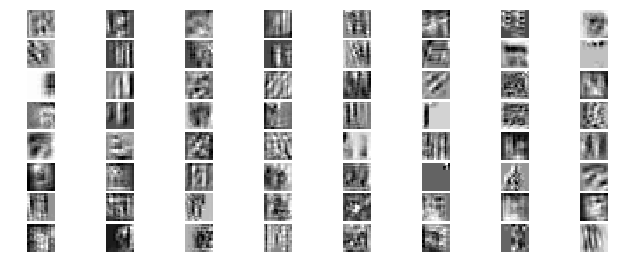

In [19]:
plt.figure(num='CNV2',figsize=(10,8))
for i in range(64):
    isolated = activations2.copy()
    isolated[:,:,:,:i] = 0
    isolated[:,:,:,i+1:] = 0#These two lines set all other features other than feature i to 0
    #print (isolated.shape)
    totals = np.sum(isolated,axis=(1,2,3))
    best = np.argmax(totals,axis=0)
    #print (totals)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        pixelactive = sess.run(unConv_2, feed_dict={featuresReLu_2: isolated})
    #print(pixelactive.shape) 
    plt.subplot(8,8,i+1)    
    plt.imshow(pixelactive[best,:,:,0],cmap="gray")
    plt.axis('off') 
plt.subplots_adjust(top=0.5, bottom=0.08, left=0.10, right=0.95, hspace=0.1,
                    wspace=0.35)
plt.show()